In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

In [32]:
# generate samples until you have the same number of samples as those
# of the training set and in the same confidence distribution
def gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train):
    train_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
    idxs, freqs = train_bucktes.index, train_bucktes.values
    ans = []

    for sample_idx, sample_conf in enumerate(y_conf_gen):

        # find interval index which contains the sample_conf (-1 if not found)
        interval_idx = np.nonzero(idxs.contains(sample_conf))[0]

        # value not fould (empty list of indices)
        if len(interval_idx) == 0:
            continue 

        # check if the bucket is not full
        interval_idx = interval_idx[0]
        if freqs[interval_idx] > 0:
            ans.append(sample_idx)
            freqs[interval_idx] -= 1 
            
    return ans

# A. Load data, preprocess, and calculate accuracy 

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for all the data

In [4]:
X_train, y_train = X, y
clf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

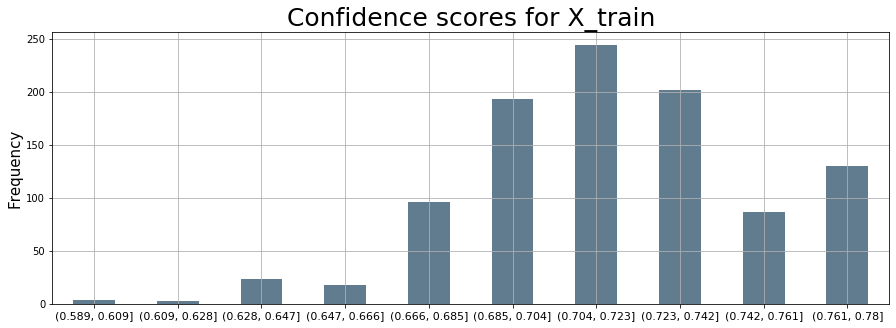

In [5]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Select C as the middle of top intervals

In [28]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [30]:
top_c_lst 

[0.599, 0.6185, 0.6375, 0.6565, 0.6755, 0.6945, 0.7135, 0.7325, 0.7515, 0.7705]

# D. Train 10 CTGANs with middle of intervals

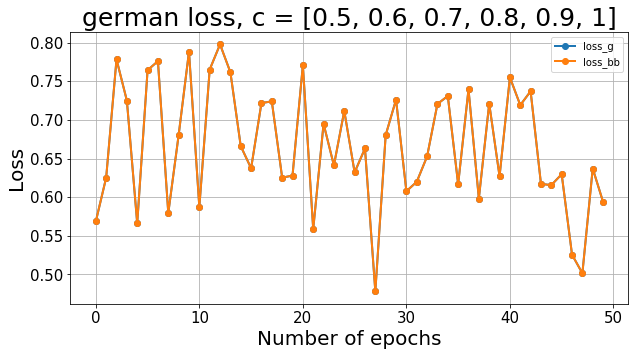

In [6]:
for c in top_c_lst:
    
    # train CTGAN
    z_features = get_noise_features(X_train, categorical_features)
    z_rows = int(0.25 * X_train.shape[0])
    z = gen_random_noise(shape=(z_rows, z_features))

    batch_size = 50
    epochs = 50
    confidence_level = c
    gen_lr = 2e-5
    loss = 'log'

    rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                                blackbox_model=rf,
                                preprocessing_pipeline=preprocessor,
                                bb_loss=loss
                                )

    hist = rf_ctgan.fit(train_data=z,
                        epochs=epochs,
                        confidence_level=confidence_level,
                        gen_lr=gen_lr,
                        verbose=False
                        )

    # rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
    # plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
    # print()
    
    
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    
    # ans is the indices of gen_data to make the same dist 
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]
    
    # y_conf_gen_same_dist, gen_data_same_dist what we want
    

### Train CTGAN with the selected C

# F. Evaluation

In [13]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_inv = scaler.inverse_transform(gen_data)
gen_data_inv = pd.DataFrame(gen_data_inv)

In [14]:
### extract similar examples from each sample in gen data
# similarities dict: gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
similarities = calc_similarities(gen_data_inv, X_train)

# Calculate coverage for each similarity threshold

In [19]:
similarities

{0: (249, 0.9),
 1: (278, 0.998),
 2: (971, 0.999),
 3: (816, 0.996),
 4: (557, 0.998),
 5: (322, 0.996),
 6: (606, 0.997),
 7: (186, 0.997),
 8: (253, 0.998),
 9: (387, 0.998),
 10: (157, 0.788),
 11: (447, 0.995),
 12: (917, 0.986),
 13: (575, 0.992),
 14: (685, 0.997),
 15: (253, 0.996),
 16: (177, 0.915),
 17: (41, 0.991),
 18: (917, 0.997),
 19: (255, 0.992),
 20: (705, 0.992),
 21: (172, 0.995),
 22: (730, 0.997),
 23: (738, 0.983),
 24: (556, 0.997),
 25: (192, 0.998),
 26: (917, 0.992),
 27: (846, 0.997),
 28: (482, 0.995),
 29: (666, 0.997),
 30: (190, 0.994),
 31: (113, 0.998),
 32: (804, 0.996),
 33: (693, 0.996),
 34: (917, 0.995),
 35: (646, 0.999),
 36: (738, 0.99),
 37: (996, 0.997),
 38: (798, 0.934),
 39: (182, 0.997),
 40: (917, 0.997),
 41: (460, 0.998),
 42: (917, 0.991),
 43: (56, 0.994),
 44: (965, 0.986),
 45: (564, 0.997),
 46: (179, 0.974),
 47: (236, 0.992),
 48: (278, 0.995),
 49: (738, 0.982),
 50: (917, 0.99),
 51: (705, 0.997),
 52: (13, 0.998),
 53: (917,

In [15]:
similarity_thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
conf_diff_thresholds = [0.01, 0.05, 0.1, 0.15, 0.2]
data = []
for threshold in similarity_thresholds:
    count = 0
    for gen_idx, (most_similiar_x_train_idx, cosine_score) in similarities.items():
        if cosine_score >= threshold:
            count += 1
    coverage = (count / gen_data_inv.shape[0]) * 100
    data.append([threshold, round(coverage)])

In [16]:
columns = ['Cosine threshold', 'Coverage']
results = pd.DataFrame(data, columns=columns)
print(f"CTGAN with confidence level = {c}")
display(results)

CTGAN with confidence level = 0.7135


,Cosine threshold,Coverage
0,0.80,96
1,0.85,94
2,0.90,93
3,0.95,89
4,0.99,74
